# Codigo ejemplo de Turbinas Eólicas

C:\Users\david\AppData\Local\Temp\ipykernel_25768\2881253797.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using cpu device
------------------------------
| time/              |       |
|    fps             | 10538 |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 40960 |
------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 2439      |
|    iterations           | 2         |
|    time_elapsed         | 33        |
|    total_timesteps      | 81920     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.09     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 8.31e+16  |
|    n_updates            | 10        |
|    policy_gradient_loss | -1.11e-07 |
|    std                  | 1         |
|    value_loss           | 1.87e+17  |
---------------------------------------
------

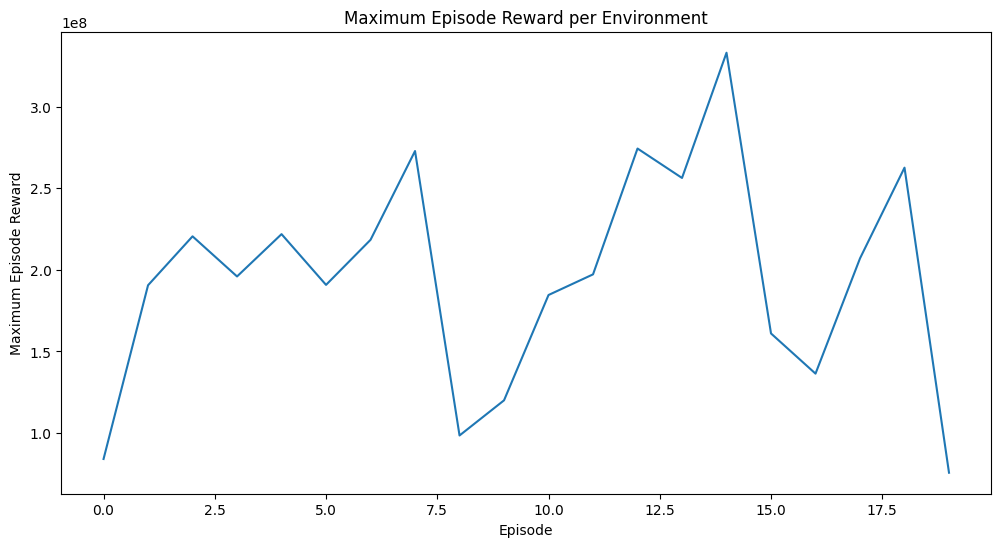

,max_reward,wind_speed,wind_direction,turbine_orientation
0,84100696.0,17.387659,1.291471,"[0.7032890915870667, 1.2438452243804932, 0.778..."
1,190571152.0,25.000000,5.437082,"[5.468646049499512, 1.4448626041412354, 4.9917..."
2,220545456.0,24.556059,2.044923,"[1.3098456859588623, 0.8292323350906372, 2.536..."
3,195961632.0,25.000000,5.666814,"[3.371098756790161, 5.173648834228516, 2.00388..."
4,221895968.0,25.000000,6.259110,"[0.08509465306997299, 0.6810091137886047, 0.60..."
5,190797552.0,25.000000,0.179664,"[0.5729971528053284, 5.172965049743652, 2.3404..."
6,218417008.0,24.018976,5.661333,"[5.427751541137695, 6.112100601196289, 4.76992..."
7,272825536.0,25.000000,1.270453,"[1.0393750667572021, 3.8895742893218994, 0.829..."
8,98501752.0,17.933290,3.606887,"[3.0859313011169434, 3.3568549156188965, 3.957..."
9,120044680.0,21.427820,3.323699,"[3.2000815868377686, 0.10696516931056976, 3.01..."


In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from IPython.display import display


# Uso PPO
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed


from custom_env.turbinas_env import TurbinasEnv



def make_env(env_id: str, rank: int, seed: int):
    def _init():
        try:
            
            env = gym.make(env_id, render_mode="human")
            env.reset(seed=seed + rank)
            return env
        except Exception as e:
            # Esto imprimirá cualquier error que ocurra dentro del entorno
            print(f"Error al inicializar el entorno: {e}")
            raise e
    set_random_seed(seed)
    return _init


if __name__ == "__main__":
    env_id = 'TurbinasEnv-v0'  # Asegúrate de que este ID coincida con el que registraste

    num_cpu = 20  # Number of processes to use
    # Create the vectorized environment

    seed = np.random.randint(0, 10)


    vec_env = DummyVecEnv([make_env(env_id, i, seed) for i in range(num_cpu)])

    

    # Stable Baselines provides you with make_vec_env() helper
    # which does exactly the previous steps for you.
    # You can choose between `DummyVecEnv` (usually faster) and `SubprocVecEnv`
    # env = make_vec_env(env_id, n_envs=num_cpu, seed=0, vec_env_cls=SubprocVecEnv)

    model = PPO("MultiInputPolicy", vec_env, verbose=1, n_steps=2048)
    #Para aumentar el numero de iteraciones cambio el valor de total_timesteps
    model.learn(total_timesteps=100_000)

    # Initialize the rewards list for each environment
        
    episode_rewards = [[] for _ in range(num_cpu)]  # List of lists to hold rewards per environment
    num_episodes = [0 for _ in range(num_cpu)]  # Track the number of episodes completed per environment

    episode_vars = []

    # Reemplaza episode_rewards y episode_vars con una estructura que pueda mantener ambas
    episode_data = [{'rewards': [], 'observations': []} for _ in range(num_cpu)]

    obs = vec_env.reset()
    
    for _ in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = vec_env.step(action)
        
        for i in range(num_cpu):
            wind_speed = obs["wind_speed"][i, 0]  # Accede al elemento del entorno i-ésimo
            wind_direction = obs["wind_direction"][i, 0]  # Accede al elemento del entorno i-ésimo
            turbine_orientations = obs["turbine_orientations"][i, :]  # Accede a la fila entera del entorno i-ésimo
            
            # Guarda las recompensas y las observaciones juntas
            episode_data[i]['rewards'].append(rewards[i])
            episode_data[i]['observations'].append({
                'wind_speed': wind_speed,
                'wind_direction': wind_direction,
                'turbine_orientation': turbine_orientations.tolist()
            })

            if dones[i]:
                num_episodes[i] += 1  # Increment episode count for the environment
                if 'reset' in info[i]:
                    obs = vec_env.reset()

    max_rewards_info = []

    for episode in episode_data:
        max_reward_index = np.argmax(episode['rewards'])
        max_reward = episode['rewards'][max_reward_index]
        max_reward_obs = episode['observations'][max_reward_index]
        
        max_rewards_info.append({
            'max_reward': max_reward,
            'observations': max_reward_obs
        })

    max_rewards = [info['max_reward'] for info in max_rewards_info]


    # And we plot the maximum reward across environments
    plt.figure(figsize=(12, 6))
    plt.plot(max_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Maximum Episode Reward')
    plt.title('Maximum Episode Reward per Environment')
    plt.savefig('reward_plot.png')
    plt.show()

    # Preparar la lista de filas
    filas = []
    for item in max_rewards_info:
        filas.append({
            'max_reward': item['max_reward'],
            'wind_speed': item['observations']['wind_speed'],
            'wind_direction': item['observations']['wind_direction'],
            'turbine_orientation': item['observations']['turbine_orientation'],
        })

    # Convertir en DataFrame
    df = pd.DataFrame(filas)

    display(df)


